In [1]:
from ast import Lambda
from unicodedata import category
import tensorflow as tf
import json

import os
import numpy as np
import cv2
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
file_path = r"D:\ObjectDetection\project\datasets\annotations_trainval2017\annotations\instances_val2017.json"
file_path_train = r"D:\ObjectDetection\project\datasets\annotations_trainval2017\annotations\instances_train2017.json"
image_path = r"D:\ObjectDetection\project\datasets\val2017\val2017"

In [4]:
with open(file_path) as file:
    jfile = json.load(file)

In [247]:
class_names = ["backgroud"]
i = 0
for item in jfile["categories"]:
    for _ in range(item["id"]-i):
        class_names.append(item["name"])
    i = item["id"]

In [367]:
def find_min_shape_and_path(image_path):
    min_x = np.inf
    min_y = np.inf
    smallest_image_path = []
    for ifile in os.listdir(image_path):
        ipath = os.path.join(image_path, ifile)
        x = cv2.imread(ipath)
        if x.shape[0] < min_y: min_y = x.shape[0]
        if x.shape[1] < min_x: min_x = x.shape[1]
            
        if x.shape[0] == min_y: smallest_image_path.append(ipath)
        if x.shape[1] == min_x: smallest_image_path.append(ipath)
        
            
    return min_x, min_y, smallest_image_path

In [369]:
minx, miny, smallest_image_path = find_min_shape_and_path(image_path)
minx, miny, smallest_image_path

(200,
 145,
 ['D:\\ObjectDetection\\project\\datasets\\val2017\\val2017\\000000000139.jpg',
  'D:\\ObjectDetection\\project\\datasets\\val2017\\val2017\\000000000139.jpg',
  'D:\\ObjectDetection\\project\\datasets\\val2017\\val2017\\000000000285.jpg',
  'D:\\ObjectDetection\\project\\datasets\\val2017\\val2017\\000000000724.jpg',
  'D:\\ObjectDetection\\project\\datasets\\val2017\\val2017\\000000000785.jpg',
  'D:\\ObjectDetection\\project\\datasets\\val2017\\val2017\\000000001353.jpg',
  'D:\\ObjectDetection\\project\\datasets\\val2017\\val2017\\000000001490.jpg',
  'D:\\ObjectDetection\\project\\datasets\\val2017\\val2017\\000000001503.jpg',
  'D:\\ObjectDetection\\project\\datasets\\val2017\\val2017\\000000001503.jpg',
  'D:\\ObjectDetection\\project\\datasets\\val2017\\val2017\\000000005586.jpg',
  'D:\\ObjectDetection\\project\\datasets\\val2017\\val2017\\000000005586.jpg',
  'D:\\ObjectDetection\\project\\datasets\\val2017\\val2017\\000000027932.jpg',
  'D:\\ObjectDetection\\proj

In [399]:
def load_and_tranform_generator():
    for ifile in os.listdir(image_path):
        ipath = os.path.join(image_path, ifile)
        iid = int(ifile.split(".")[0])
        x = cv2.imread(ipath)
        y = [an["bbox"] + [an["category_id"]] for an in jfile["annotations"] if an["image_id"] == iid]
        yield x, tuple(y)

def resize_dataset(x, y, resize_dims=(300, 350), resize=True):    
    y_ = tf.shape(x)[0]
    x_ = tf.shape(x)[1]

    target_size = tf.constant(resize_dims)
    
    scale = tf.divide(target_size, (y_, x_))
    if resize: x = tf.image.resize(x, target_size)
    x = tf.divide(x, 255)
    
    boxes, classes = tf.split(y, (4, 1), axis=-1)
    if resize: boxes = tf.multiply(boxes, (scale[1], scale[0], scale[1], scale[0]))
    y = tf.concat([boxes, classes], axis=-1)
    paddings = [[0, 50 - tf.shape(y)[0]], [0, 0]]
    y = tf.pad(y, paddings)
    return x, y

def visulizing_pipeline(batch_size):
    dataset = tf.data.Dataset.from_generator(load_and_tranform_generator, 
            output_signature=(tf.TensorSpec(shape=(None, None, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(None, 5), dtype=tf.float32)))
    dataset = dataset.map(lambda x, y: resize_dataset(x, y))
    dataset = dataset.batch(batch_size)

    return dataset

In [400]:
def draw_labels(xs, ys, class_names):
    imgs = xs.numpy()
    for h in range(imgs.shape[0]):
        img = imgs[h]
        y = ys[h] 
        boxes, classes = tf.split(y, (4, 1), axis=-1)
        classes = tf.cast(classes, dtype=tf.int32)   
        classes = classes[..., 0]
        for i in range(len(boxes)):
            if classes[i] == 0: continue
            x1y1 = tuple(np.array(boxes[i][0:2]).astype(np.int32))
            x2y2 = tuple(np.array(boxes[i][0:2] + boxes[i][2:4]).astype(np.int32))
            img = cv2.rectangle(img, x1y1, x2y2, (1, 0, 0), 2)
            img = cv2.putText(img, class_names[classes[i]],
                            x1y1, cv2.FONT_HERSHEY_SIMPLEX,
                            0.5, (0, 0, 1), 1)
        imgs[h] = img
    return imgs

In [401]:
batch_size = 4
dataset = visulizing_pipeline(batch_size)

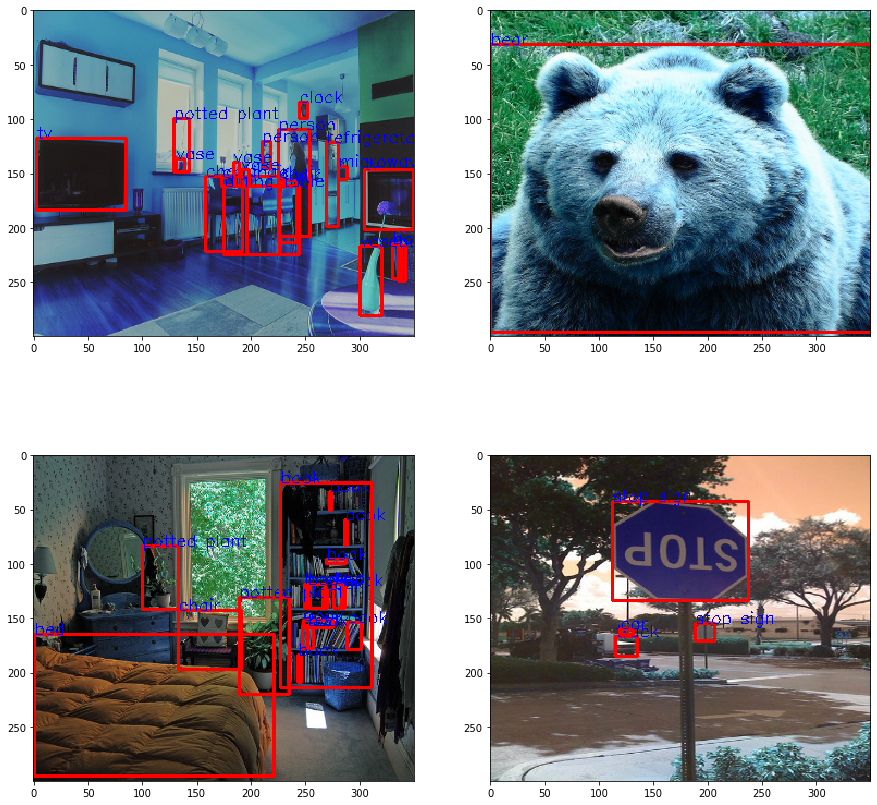

In [402]:
fig = plt.figure(figsize=(15, 15))  # width, height in inches
for i in dataset.take(1):
    xs, ys = i
    imgs = draw_labels(xs, ys, class_names)
    for j in range(batch_size):
        sub = fig.add_subplot(batch_size//2, batch_size//2, j + 1)
        sub.imshow(imgs[j,:,:, :], interpolation='nearest')
plt.show()